In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images  # go to 3 dots on right upper corner and click on API command

 97% 461M/476M [00:07<00:00, 45.5MB/s]
100% 476M/476M [00:07<00:00, 66.8MB/s]


In [4]:
!unzip /content/ai-generated-images-vs-real-images.zip

Archive:  /content/ai-generated-images-vs-real-images.zip
  inflating: AiArtData/AiArtData/-how-important-people-from-the-past-really-looked-11-Pics-5ffd5c0f4d77f__880.jpg  
  inflating: AiArtData/AiArtData/-s-fluffy-fur-and-round-features-immediately-melted-the-viewer-s-heart-photo.jpg  
  inflating: AiArtData/AiArtData/-using-generative-ai-technology-landscape-pattern-abstract-concept-269270897.jpg  
  inflating: AiArtData/AiArtData/-yellow-kimono-with-a-golden-crown-and-a-very-detailed-Barn-owl-copy-800x800.jpg  
  inflating: AiArtData/AiArtData/.amazonaws.com2Fpublic2Fimages2Ff89de3bb-279b-42c9-9822-a653fb5b21e6_600x480.png  
  inflating: AiArtData/AiArtData/0002_AI-in-animal-classification.png  
  inflating: AiArtData/AiArtData/00urban_biodiversity_landscape_architecture_14ed209d-45ca-4c57-b995-4d1552813cc1.jpg  
  inflating: AiArtData/AiArtData/03a3gbCKfH8dDJnjhHLuHDf-1.fit_lim.v1665523315.png  
  inflating: AiArtData/AiArtData/06as5rHi0sgG4W2Tq.png  
  inflating: AiArtData/AiArt

In [34]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
from PIL import Image
np.random.seed(2024)
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

In [6]:
ai_images_path = "/content/AiArtData/AiArtData"
real_images_path = "/content/RealArt/RealArt"


In [7]:
ai = 0
for filename in os.listdir(ai_images_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        ai += 1

real = 0
for filename in os.listdir(real_images_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        real += 1
print(real)
print("Total number of datasets:", ai+real)

434
Total number of datasets: 970


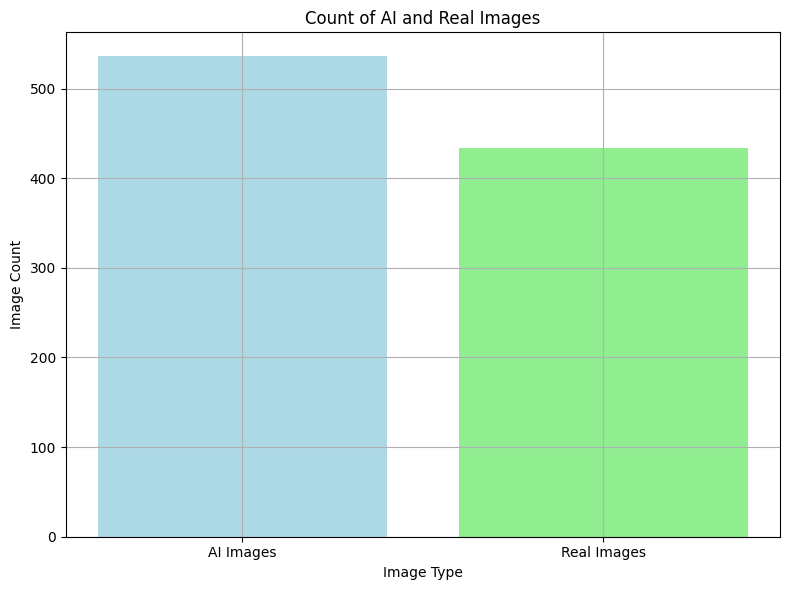

In [8]:

image_types = ["AI Images", "Real Images"]
image_counts = [ai, real]

plt.figure(figsize=(8, 6))
plt.bar(image_types, image_counts, color=['lightblue', 'lightgreen'])
plt.xlabel("Image Type")
plt.ylabel("Image Count")
plt.title("Count of AI and Real Images")
plt.xticks(rotation=0)
plt.grid(True)

plt.tight_layout()
plt.show()



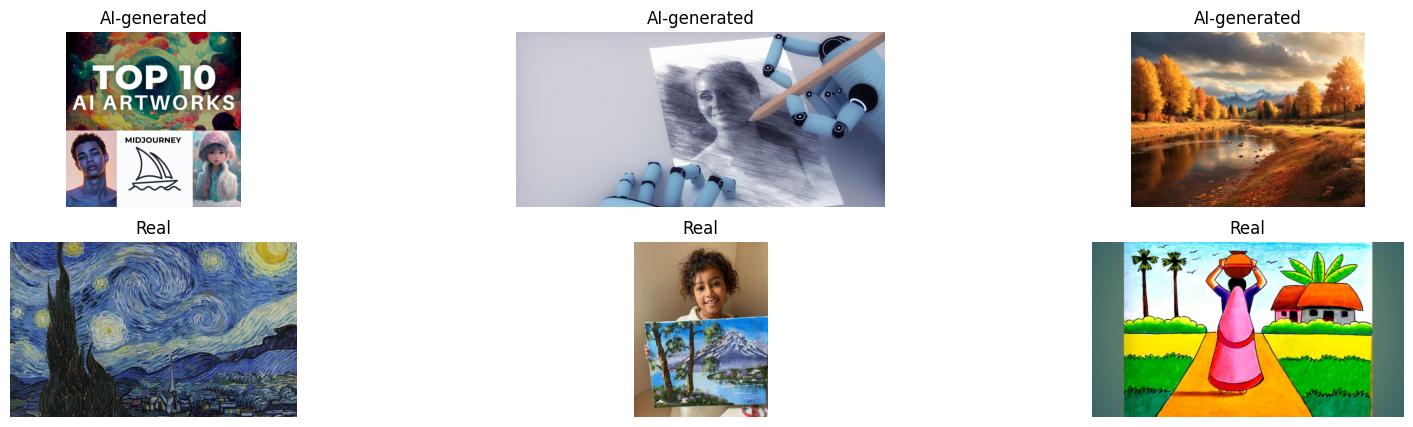

In [9]:
def display_sample_images(ai_images_path, real_images_path, num_images=3):

    fig, axes = plt.subplots(2, num_images, figsize=(20, 5))
    ai_image_paths = [os.path.join(ai_images_path, filename) for filename in os.listdir(ai_images_path)[:num_images]]
    for i, image_path in enumerate(ai_image_paths):
        ax = axes[0, i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title('AI-generated')
        ax.axis('off')

    real_image_paths = [os.path.join(real_images_path, filename) for filename in os.listdir(real_images_path)[:num_images]]
    for i, image_path in enumerate(real_image_paths):
        ax = axes[1, i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title('Real')
        ax.axis('off')

    plt.show()

display_sample_images(ai_images_path, real_images_path)


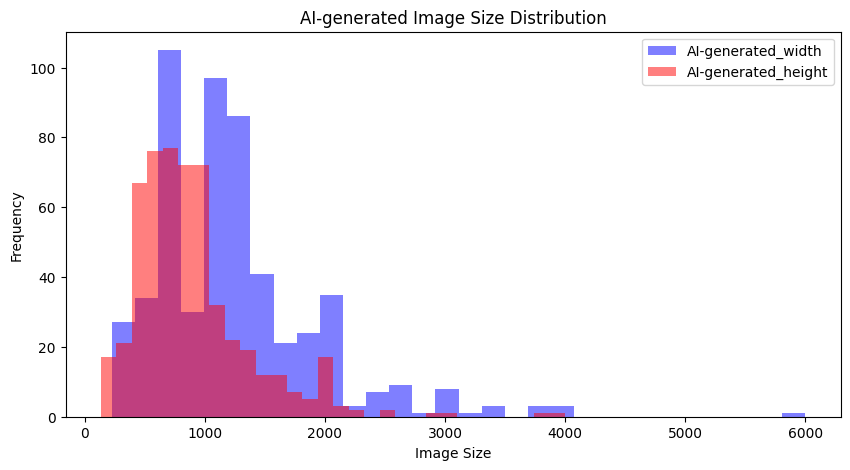

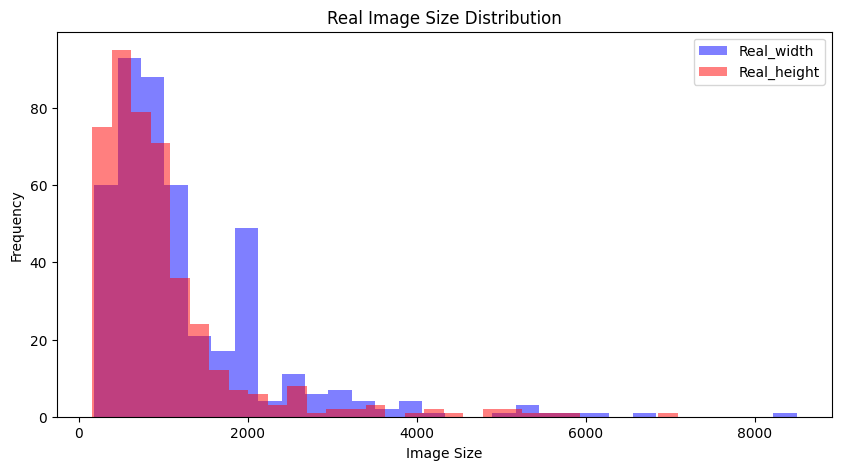

In [10]:
def plot_image_size_distribution(ai_images_path, real_images_path):

    ai_image_paths = [os.path.join(ai_images_path, filename) for filename in os.listdir(ai_images_path)]
    real_image_paths = [os.path.join(real_images_path, filename) for filename in os.listdir(real_images_path)]

    ai_image_sizes = [(Image.open(image_path).size) for image_path in ai_image_paths]
    real_image_sizes = [(Image.open(image_path).size) for image_path in real_image_paths]

    ai_widths = [size[0] for size in ai_image_sizes]
    ai_heights = [size[1] for size in ai_image_sizes]

    real_widths = [size[0] for size in real_image_sizes]
    real_heights = [size[1] for size in real_image_sizes]


    plt.figure(figsize=(10, 5))
    plt.hist(ai_widths, bins=30, alpha=0.5, label='AI-generated_width', color='blue')
    plt.hist(ai_heights, bins=30, alpha=0.5, label='AI-generated_height', color='red')
    plt.title('AI-generated Image Size Distribution')
    plt.xlabel('Image Size')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.hist(real_widths, bins=30, alpha=0.5, label='Real_width', color='blue')
    plt.hist(real_heights, bins=30, alpha=0.5, label='Real_height', color='red')
    plt.title('Real Image Size Distribution')
    plt.xlabel('Image Size')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


plot_image_size_distribution(ai_images_path, real_images_path)


# Data Balancing

In [11]:
import random

def balance_dataset(real_images_path, ai_images_path, new_count=None):

    real_image_count = len(os.listdir(real_images_path))
    ai_image_count = len(os.listdir(ai_images_path))

    if new_count is None:
        target_count = real_image_count
    else:
        target_count = new_count

    images_to_remove = max(ai_image_count - target_count, 0)
    images_to_keep = ai_image_count - images_to_remove

    if images_to_remove > 0:
        print(f"Removing {images_to_remove} images from the AI-generated folder...")

        ai_generated_image_paths = [
            os.path.join(ai_images_path, f) for f in os.listdir(ai_images_path)
        ]
        random.shuffle(ai_generated_image_paths)


        stratified_indices = random.sample(range(ai_image_count), images_to_keep)
        images_to_keep_paths = [ai_generated_image_paths[i] for i in stratified_indices]

        for image_path in ai_generated_image_paths:
            if image_path not in images_to_keep_paths:
                try:
                    os.remove(image_path)
                except OSError:
                    print(f"Error removing image: {image_path}")

    elif images_to_remove < 0:
        print(f"AI-generated images ({ai_image_count}) already less than or equal to real images ({real_image_count}). No deletion needed.")
    else:
        print("Dataset already balanced (equal number of real and AI-generated images).")

    print("Dataset balancing completed.")



target_count = 434

balance_dataset(real_images_path, ai_images_path, target_count)


Removing 105 images from the AI-generated folder...
Dataset balancing completed.


# Model Building

In [16]:
IMG_WIDTH, IMG_HEIGHT = 224, 224

real_image_files = [os.path.join(real_images_path, f) for f in os.listdir(real_images_path)]
ai_image_files = [os.path.join(ai_images_path, f) for f in os.listdir(ai_images_path)]

image_files = real_image_files + ai_image_files
labels = [0] * len(real_image_files) + [1] * len(ai_image_files)

In [18]:
import pandas as pd
df = pd.DataFrame({'image_files': image_files, 'labels': labels})

X_train, X_test, y_train, y_test = train_test_split(df['image_files'], df['labels'], test_size=0.2, random_state=42)

In [19]:
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',rescale=1./255  )
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
df['labels'] = df['labels'].astype(str)
train_generator = train_datagen.flow_from_dataframe(dataframe=df, x_col='image_files', y_col='labels', target_size=(IMG_WIDTH, IMG_HEIGHT),batch_size=32, class_mode='binary')
validation_generator = test_datagen.flow_from_dataframe(dataframe=df, x_col='image_files', y_col='labels', target_size=(IMG_WIDTH, IMG_HEIGHT),batch_size=32,class_mode='binary')

Found 866 validated image filenames belonging to 2 classes.
Found 866 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="image_files". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="image_files". These filename(s) will be ignored.
  warnings.warn(


# Using CNN

In [43]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [44]:
history1= model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/10
 9/27 [=========>....................] - ETA: 1:09 - loss: 0.7667 - accuracy: 0.5155

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


27/27 [==============================] - 167s 6s/step - loss: 0.7083 - accuracy: 0.5480 - val_loss: 0.6955 - val_accuracy: 0.5046
Epoch 2/10
27/27 [==============================] - 188s 7s/step - loss: 0.6949 - accuracy: 0.5552 - val_loss: 0.6782 - val_accuracy: 0.5822
Epoch 3/10
27/27 [==============================] - 187s 7s/step - loss: 0.6756 - accuracy: 0.5815 - val_loss: 0.6585 - val_accuracy: 0.6192
Epoch 4/10
27/27 [==============================] - 186s 7s/step - loss: 0.6715 - accuracy: 0.5959 - val_loss: 0.6510 - val_accuracy: 0.6076
Epoch 5/10
27/27 [==============================] - 152s 6s/step - loss: 0.6550 - accuracy: 0.6127 - val_loss: 0.6620 - val_accuracy: 0.5799
Epoch 6/10
27/27 [==============================] - 186s 7s/step - loss: 0.6667 - accuracy: 0.5995 - val_loss: 0.6436 - val_accuracy: 0.6157
Epoch 7/10
27/27 [==============================] - 187s 7s/step - loss: 0.6380 - accuracy: 0.6475 - val_loss: 0.6747 - val_accuracy: 0.5822
Epoch 8/10
27/27 [======

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "conv2d_3" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=string)
      • training=False
      • mask=None


# Mobile Net V2

In [45]:
mobilenet_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')

# Freeze the pre-trained layers
mobilenet_model.trainable = False

model5 = Sequential([
    mobilenet_model,
    Dense(128, activation='relu'),  # Hidden layer
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')
])

In [46]:
# Compile the model
model5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# Train the model
history5= model5.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
25/27 [==========================>...] - ETA: 5s - loss: 0.7236 - accuracy: 0.5870

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


27/27 [==============================] - 143s 5s/step - loss: 0.7177 - accuracy: 0.5887 - val_loss: 0.5435 - val_accuracy: 0.7477
Epoch 2/10
27/27 [==============================] - 163s 6s/step - loss: 0.5653 - accuracy: 0.7026 - val_loss: 0.4727 - val_accuracy: 0.7986
Epoch 3/10
27/27 [==============================] - 134s 5s/step - loss: 0.5325 - accuracy: 0.7482 - val_loss: 0.4550 - val_accuracy: 0.7975
Epoch 4/10
27/27 [==============================] - 162s 6s/step - loss: 0.4770 - accuracy: 0.7746 - val_loss: 0.4644 - val_accuracy: 0.7731
Epoch 5/10
27/27 [==============================] - 160s 6s/step - loss: 0.4458 - accuracy: 0.7842 - val_loss: 0.4249 - val_accuracy: 0.8009
Epoch 6/10
27/27 [==============================] - 141s 5s/step - loss: 0.4542 - accuracy: 0.8070 - val_loss: 0.3868 - val_accuracy: 0.8507
Epoch 7/10
27/27 [==============================] - 142s 5s/step - loss: 0.3962 - accuracy: 0.8310 - val_loss: 0.3599 - val_accuracy: 0.8461
Epoch 8/10
27/27 [======

In [29]:
model5.save("model_cnn_87.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Graphs

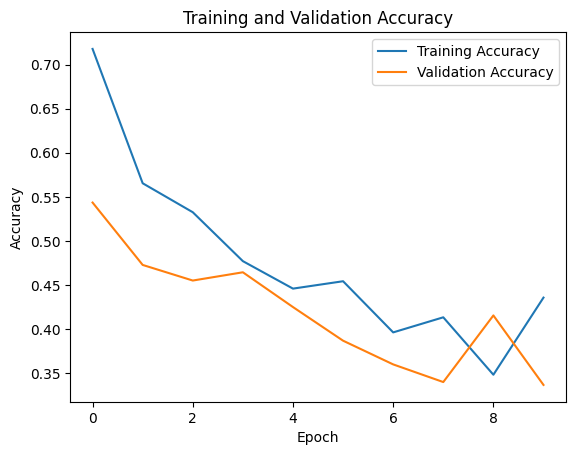

In [31]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

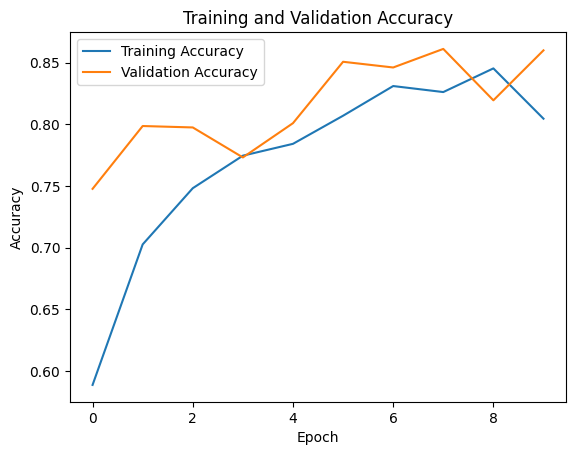

In [32]:
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predictions

In [36]:
model_path = "/content/model_cnn_87.h5"
model = tf.keras.models.load_model(model_path)
img_path = "/content/RealArt/RealArt/10-tips-for-stunning-portrait-photography-7.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
print(img)
if prediction[0] > 0.5:
    print("AI-generated")
else:
    print("Real")

1/1 [==============================] - 1s 1s/step
<PIL.Image.Image image mode=RGB size=224x224 at 0x7B38C810F250>
Real


1/1 [==============================] - 0s 50ms/step
Prediction: Real image


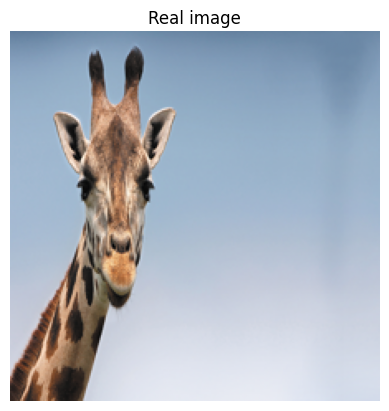

In [38]:
try:
    input_image = Image.open('/content/RealArt/RealArt/2020-03-feature-giraffe_tcm7-269465.png')
    input_image = input_image.resize((IMG_WIDTH, IMG_HEIGHT))
    input_image = np.array(input_image) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
except Exception as e:
    print("Error loading or preprocessing the input image:", e)

try:
    predictions = model.predict(input_image)
    if predictions[0][0] >= 0.5:
        prediction_text = "AI-generated image"
    else:
        prediction_text = "Real image"
    print("Prediction:", prediction_text)

    plt.imshow(input_image[0])
    plt.title(prediction_text)
    plt.axis('off')
    plt.show()

except Exception as e:
    print("Error making predictions:", e)

1/1 [==============================] - 0s 51ms/step
Prediction: AI-generated image


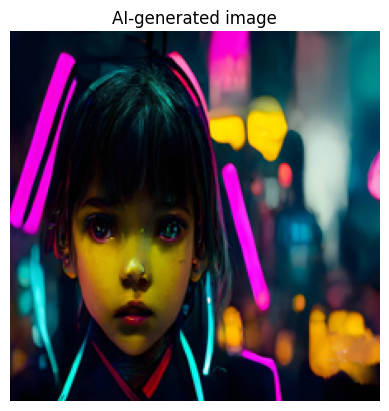

In [39]:
try:
    input_image = Image.open('/content/AiArtData/AiArtData/082922_GeneratedArtAI_02_teh_z1b_04.jpg')
    input_image = input_image.resize((IMG_WIDTH, IMG_HEIGHT))
    input_image = np.array(input_image) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
except Exception as e:
    print("Error loading or preprocessing the input image:", e)

try:
    predictions = model.predict(input_image)
    if predictions[0][0] >= 0.5:
        prediction_text = "AI-generated image"
    else:
        prediction_text = "Real image"
    print("Prediction:", prediction_text)

    plt.imshow(input_image[0])
    plt.title(prediction_text)
    plt.axis('off')
    plt.show()

except Exception as e:
    print("Error making predictions:", e)

1/1 [==============================] - 0s 53ms/step
Prediction: Real image


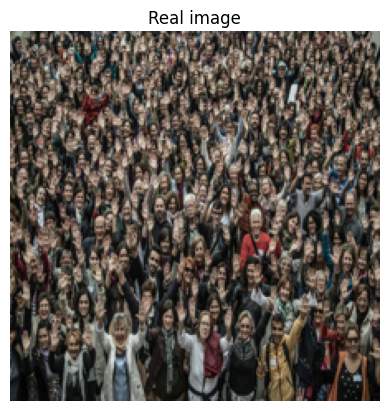

In [40]:
try:
    input_image = Image.open('/content/RealArt/RealArt/33100scr.jpg')
    input_image = input_image.resize((IMG_WIDTH, IMG_HEIGHT))
    input_image = np.array(input_image) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
except Exception as e:
    print("Error loading or preprocessing the input image:", e)

try:
    predictions = model.predict(input_image)
    if predictions[0][0] >= 0.5:
        prediction_text = "AI-generated image"
    else:
        prediction_text = "Real image"
    print("Prediction:", prediction_text)

    plt.imshow(input_image[0])
    plt.title(prediction_text)
    plt.axis('off')
    plt.show()

except Exception as e:
    print("Error making predictions:", e)

1/1 [==============================] - 0s 49ms/step
Prediction: AI-generated image


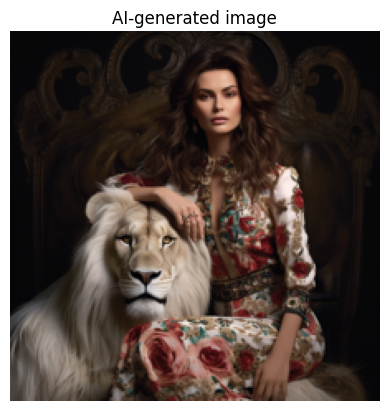

In [41]:
try:
    input_image = Image.open('/content/AiArtData/AiArtData/1Mcde2p8rG0uUjwwQ-tGWLg.png')
    input_image = input_image.resize((IMG_WIDTH, IMG_HEIGHT))
    input_image = np.array(input_image) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
except Exception as e:
    print("Error loading or preprocessing the input image:", e)

try:
    predictions = model.predict(input_image)
    if predictions[0][0] >= 0.5:
        prediction_text = "AI-generated image"
    else:
        prediction_text = "Real image"
    print("Prediction:", prediction_text)

    plt.imshow(input_image[0])
    plt.title(prediction_text)
    plt.axis('off')
    plt.show()

except Exception as e:
    print("Error making predictions:", e)

In [48]:
import pickle

In [49]:
pickle.dump(model5,open('model1.pkl',"wb"))

In [ ]:
model5.save("model1.h5")
